We want to analyze participants and patterns of participation across IETF groups. How many people participate, in which groups, how does affiliation, gender, RFC authorship or other characteristics relate to levels of participation, and a variety of other related questions. How do groups relate to one another? Which participants provide important connections between groups?

## Setup and gather data

Start by importing the necessary libraries.

In [1]:
%matplotlib inline
import bigbang.mailman as mailman
import bigbang.graph as graph
import bigbang.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import scipy.cluster.hierarchy as sch
import email

In [2]:
#pd.options.display.mpl_style = 'default' # pandas has a set of preferred graph formatting options
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

Let's start with a single IETF mailing list. (Later, we can expand to all current groups, or all IETF lists ever.)

In [3]:
list_url = 'https://www.ietf.org/mail-archive/text/perpass/' # perpass happens to be one that I subscribe to

ietf_archives_dir = '../../ietf-archives' # relative location of the ietf-archives directory/repo

list_archive = mailman.open_list_archives(list_url, ietf_archives_dir)
activity = Archive(list_archive).get_activity()

Opening 43 archive files


In [4]:
people = None
people = pd.DataFrame(activity.sum(0), columns=['perpass']) # sum the message count, rather than by date

In [5]:
people.describe()

,perpass
count,261.000000
mean,8.015326
std,18.733961
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,231.000000


Now repeat, parsing the archives and collecting the activities for all the mailing lists in the corpus. To make this faster, we try to open pre-created `-activity.csv` files which contain the activity summary for the full list archive. These files are created with `bin/mail_to_activity.py` or might be included in the mailing list archive repository.

In [6]:
f = open('ietf_lists_normalized.txt', 'r')
ietf_lists = set(f.readlines()) # remove duplicates, which is a bug in list maintenance

In [7]:
list_activities = []

for list_url in ietf_lists:
    try:
        activity_summary = mailman.open_activity_summary(list_url, ietf_archives_dir)
        if activity_summary is not None:
            list_activities.append((list_url, activity_summary))
    except Exception as e:
        print str(e)

In [8]:
len(list_activities)

316

Merge all of the activity summaries together, so that every row is a "From" field, with a column for every mailing list and a cell that includes the number of messages sent to that list. This will be a very sparse, 2-d table. **This operation is a little slow.** Don't repeat this operation without recreating `people` from the cells above.

In [9]:
list_columns = []
for (list_url, activity_summary) in list_activities:
    list_name = mailman.get_list_name(list_url)
    activity_summary.rename(columns={'Message Count': list_name}, inplace=True) # name the message count column for the list
    people = pd.merge(people, activity_summary, how='outer', left_index=True, right_index=True)
    list_columns.append(list_name) # keep a list of the columns that specifically represent mailing list message counts

In [10]:
# the original message column was duplicated during the merge process, so we remove it here
people = people.drop(columns=['perpass_y'])
people = people.rename(columns={'perpass_x':'perpass'})

In [11]:
people.describe()

,perpass,enum,rip,yam,l2vpn,bgmp,ima,opsawg,bundled-domain-names,video-codec,...,perc,payload,trill,ietf-nntp,spud,imss,dhcwg,rmonmib,public-iri,lemonade
count,261.000000,769.000000,369.000000,65.000000,602.000000,74.000000,207.000000,595.000000,17.000000,102.000000,...,58.000000,207.000000,472.000000,1.0,78.000000,1386.000000,1827.000000,1183.000000,189.000000,288.000000
mean,8.015326,9.338101,1.601626,12.861538,7.468439,2.148649,26.710145,8.710924,2.411765,5.441176,...,13.362069,8.304348,16.811441,0.0,9.884615,1.704906,11.452107,2.658495,12.804233,17.909722
std,18.733961,33.295553,4.827018,24.152431,18.298046,3.090784,76.347272,24.628358,2.670647,9.874032,...,20.529566,18.610445,63.417268,NaN,18.352240,5.865416,61.757912,17.197470,31.897255,53.059616
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.250000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,1.000000,1.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,...,5.500000,3.000000,3.000000,0.0,4.000000,1.000000,2.000000,1.000000,2.000000,2.000000
75%,7.000000,4.000000,1.000000,10.000000,5.000000,1.000000,16.500000,6.000000,2.000000,5.000000,...,11.500000,7.000000,8.000000,0.0,8.750000,1.000000,5.000000,1.000000,8.000000,7.250000
max,231.000000,502.000000,85.000000,133.000000,197.000000,20.000000,799.000000,349.000000,11.000000,77.000000,...,96.000000,145.000000,1114.000000,0.0,99.000000,91.000000,1423.000000,496.000000,252.000000,493.000000


In [12]:
# not sure how the index ended up with NaN values, but need to change them to strings here so additional steps will work
new_index = people.index.fillna('missing')
people.index = new_index

Split out the email address and header name from the From header we started with.

In [13]:
froms = pd.Series(people.index)
emails = froms.apply(lambda x: email.utils.parseaddr(x)[1])
emails.index = people.index
names = froms.apply(lambda x: email.utils.parseaddr(x)[0])
names.index = people.index
people['email'] = emails
people['name'] = names

Let's create some summary statistical columns.

In [14]:
people['Total Messages'] = people[list_columns].sum(axis=1)
people['Number of Groups'] = people[list_columns].count(axis=1)
people['Median Messages per Group'] = people[list_columns].median(axis=1)

In [15]:
people['Total Messages'].sum()

1203307.0

In [16]:
people['Total Messages'].describe()

count    101510.000000
mean         11.854073
std         120.914508
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       17452.000000
Name: Total Messages, dtype: float64

In this corpus, **101,510** "people" sent a combined total of **1.2 million messages**. Most people sent only 1 message.

## Participation patterns

The vast majority of people send only a few messages, and to only a couple of lists. (These histograms use a log axis for Y, without which you couldn't even see the columns besides the first.)

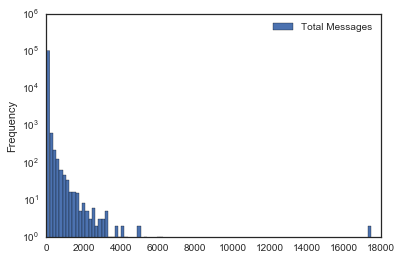

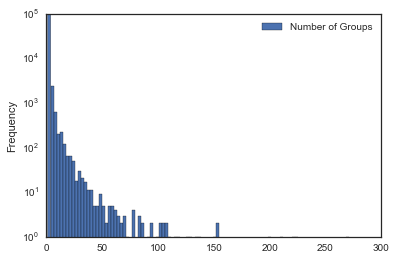

In [17]:
people[['Total Messages']].plot(kind='hist', bins=100, logy=True, logx=False)
people[['Number of Groups']].plot(kind='hist', bins=100, logy=True, logx=False)

Let's limit our analysis for now to people who have sent at least 5 messages. We will also create log base 10 versions of our summary columns for easier graphing later.

In [18]:
working = people[people['Total Messages'] > 5]

working['Total Messages (log)'] = np.log10(working['Total Messages'])
working['Number of Groups (log)'] = np.log10(working['Number of Groups'])


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The median number of messages that a user sends to a group is also heavily weighted towards a small number, but the curve doesn't seem to drop off in the same extreme manner. There is a non-random tendency to send some messages to a group?

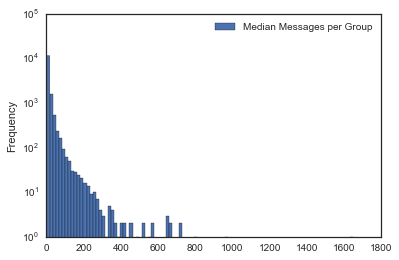

In [19]:
working[['Median Messages per Group']].plot(kind='hist', bins=100, logy=True)

Is there a relationship between the number of groups that a user has sent messages to and the number of messages that user has sent (total, or the median number to groups)?

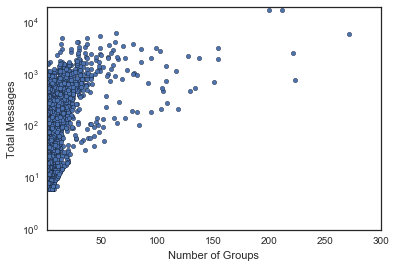

In [20]:
working.plot.scatter('Number of Groups','Total Messages', xlim=(1,300), ylim=(1,20000), logx=False, logy=True)

It appears that there are interesting outliers here. Some who send a couple messages each to a large number of groups, but then a separate group of outliers that sends lots of messages and to lots of groups. That might be an elite component worthy of separate analysis.

A density graph will show, however, that while there are people who send many messages to a small number of groups, still, most people are clustered around sending few messages, to few groups.

/usr/local/lib/python2.7/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


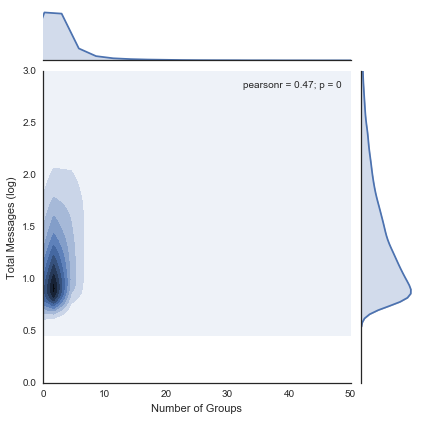

In [21]:
sns.jointplot(x='Number of Groups',y='Total Messages (log)', data=working, kind="kde", xlim=(0,50), ylim=(0,3));

## Relationships between groups and participants

Can we learn implicit relationships between groups based on the messaging patterns of participants?

### PCA

We want to work with just the data of people and how many messages they sent to each group.

In [22]:
df = people[people['Total Messages'] > 5]

df = df.drop(columns=['email','name','Total Messages','Number of Groups','Median Messages per Group'])
df = df.fillna(0)

Principal Component Analysis (PCA) will seek to explain the most variance in the samples (participants) based on the features (messages sent to different lists). Let's try with two components and see what PCA sees as the most distinguishing dimensions of IETF participation.

In [23]:
import sklearn
from sklearn.decomposition import PCA

scaled = sklearn.preprocessing.maxabs_scale(df)

pca = PCA(n_components=2, whiten=True)
pca.fit(scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [24]:
components_frame = pd.DataFrame(pca.components_)
components_frame.columns = df.columns
components_frame

,perpass,enum,rip,yam,l2vpn,bgmp,ima,opsawg,bundled-domain-names,video-codec,...,perc,payload,trill,ietf-nntp,spud,imss,dhcwg,rmonmib,public-iri,lemonade
0,0.030127,0.058292,0.003969,0.030922,0.172658,0.059051,0.026730,0.105092,0.005249,0.029205,...,0.044595,0.136939,0.041686,-0.0,0.021962,0.063578,0.076615,0.033714,0.017862,0.048214
1,-0.050187,0.056799,0.005827,0.008344,0.003475,0.073483,0.007039,-0.040954,-0.013285,-0.037760,...,-0.064697,-0.115755,-0.027195,-0.0,-0.025871,0.091040,0.036787,0.043550,-0.031863,0.042177


In [25]:
for i, row in components_frame.iterrows():
    print '\nComponent %d' % i
    r = row.sort_values(ascending=False)
    print 'Most positive correlation:\n %s' % r[:5].index.values
    print 'Most negative correlation:\n %s' % r[-5:].index.values


Component 0
Most positive correlation:
 ['l3vpn' 'l2vpn' 'rtgwg' 'idr' 'ippm']
Most negative correlation:
 ['ietf-dav-versioning' 'ietf-nntp' 'idna-update' 'ntpwg' 'cicm']

Component 1
Most positive correlation:
 ['mext' 'mip6' 'monami6' 'mipshop' 'netlmm']
Most negative correlation:
 ['bess' 'http-auth' 'dispatch' 'curdle' 'payload']


Component 0 is mostly routing (Layer 3 and Layer 2 VPNs, the routing area working group, interdomain routing. (IP Performance/Measurement seems different -- is it related?)

Component 1 is all Internet area groups, mostly related to IPv6, and specifically different groups working on mobility-related extensions to IPv6.

When data was unscaled, PCA components seemed to connect to ops and ipv6, a significantly different result.

For our two components, we can see which features are most positively correlated and which are most negatively correlated. On positive correlation, looking up these groups, it seems like there is some meaningful coherence here. On Component 0, we see groups in the "ops" area: groups related to the management, configuration and measurement of networks. On the other component, we see groups in the Internet and transport areas: groups related to IPv6, the transport area and PSTN transport.

That we see such different results when the data is first scaled by each feature perhaps suggests that the initial analysis was just picking up on the largest groups.

In [26]:
pca.explained_variance_

array([0.00289891, 0.00155329])

The explained variance by our components seems extremely tiny.

With two components (or the two most significant components), we can attempt a basic visualization as a scatter plot.

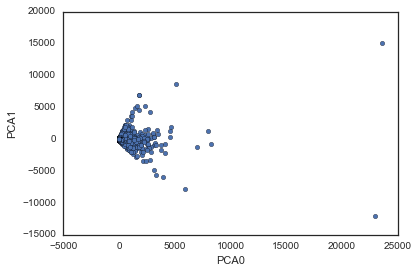

In [27]:
component_df = pd.DataFrame(pca.transform(df), columns=['PCA%i' % i for i in range(2)], index=df.index)
component_df.plot.scatter(x='PCA0',y='PCA1')

And with a larger number of components?

In [28]:
pca = PCA(n_components=10, whiten=True)
pca.fit(scaled)
components_frame = pd.DataFrame(pca.components_)
components_frame.columns = df.columns
for i, row in components_frame.iterrows():
    print '\nComponent %d' % i
    r = row.sort_values(ascending=False)
    print 'Most positive correlation:\n %s' % r[:5].index.values
    print 'Most negative correlation:\n %s' % r[-5:].index.values


Component 0
Most positive correlation:
 ['l3vpn' 'l2vpn' 'rtgwg' 'idr' 'ippm']
Most negative correlation:
 ['ietf-dav-versioning' 'idna-update' 'ntpwg' 'ietf-nntp' 'cicm']

Component 1
Most positive correlation:
 ['mext' 'mip6' 'monami6' 'mipshop' 'netlmm']
Most negative correlation:
 ['bess' 'http-auth' 'dispatch' 'curdle' 'payload']

Component 2
Most positive correlation:
 ['mext' 'monami6' 'ianaplan' 'mtgvenue' 'iasa20']
Most negative correlation:
 ['xcon' 'ipcdn' 'policy' 'adslmib' 'l3vpn']

Component 3
Most positive correlation:
 ['dispatch' 'sipcore' 'martini' 'rtcweb' 'stir']
Most negative correlation:
 ['l2vpn' 'status' 'l3vpn' 'idr' 'rtgwg']

Component 4
Most positive correlation:
 ['ianaplan' 'mtgvenue' 'v6ops' 'iasa20' 'policy']
Most negative correlation:
 ['netext' 'netlmm' 'mip6' 'monami6' 'mext']

Component 5
Most positive correlation:
 ['v6ops' 'dispatch' 'mtgvenue' 'ipv6' 'shim6']
Most negative correlation:
 ['tls' 'websec' 'http-auth' 'woes' 'json']

Component 6
Most 

There are definitely subject domain areas in these lists (the last one, for example, on groups related to phone calls and emergency services). Also interesting is the presence of some meta-topics, like `mtgvenue` or `policy` or `iasa20` (an IETF governance topic).

_Future work: we might be able to use this sparse matrix of participation in different lists to provide recommendations of similarity. "People who send messages to the same mix of groups you send to also like this other list" or "People who like this list, also often like this list"._

### Betweenness, PageRank and graph visualization

Because we have people and the groups they send to, we can construct a _bipartite graph_.

We'll use just the top 5000 people, in order to make complicated calculations run faster.

In [89]:
df = people.sort_values(by="Total Messages",ascending=False)[:5000]
df = df.drop(columns=['email','name','Total Messages','Number of Groups','Median Messages per Group'])
df = df.fillna(0)

In [90]:
import networkx as nx

G = nx.Graph()

for group in df.columns:
    G.add_node(group,type="group")
    
for name, data in df.iterrows():
    G.add_node(name,type="person")
    
    for group, weight in data.iteritems():
        if weight > 0:
            G.add_edge(name,group,weight=weight)

In [91]:
nx.is_bipartite(G)

True

Yep, it is bipartite! Now, we can export a graph file for use in visualization software Gephi.

In [92]:
nx.write_gexf(G,'ietf-participation-bipartite.gexf')

In [77]:
people_nodes, group_nodes = nx.algorithms.bipartite.sets(G)

We can calculate the "PageRank" of each person and group, using the weights (number of messages) between groups and people to distribute a kind of influence.

In [36]:
pr = nx.pagerank(G, weight="weight")

In [37]:
nx.set_node_attributes(G, "pagerank", pr)

In [79]:
sorted([node for node in list(G.nodes(data=True)) 
        if node[1]['type'] == 'group'], 
       key=lambda x: x[1]['pagerank'], 
       reverse =True)[:10]

[('pkix',
  {'closeness': 0.3559326859845808,
   'pagerank': 0.013142326567840455,
   'type': 'group'}),
 ('v6ops',
  {'closeness': 0.359521233877267,
   'pagerank': 0.01199540427731154,
   'type': 'group'}),
 ('manet',
  {'closeness': 0.35557776735183255,
   'pagerank': 0.011617411862990278,
   'type': 'group'}),
 ('megaco',
  {'closeness': 0.34997746321585244,
   'pagerank': 0.010425997285129628,
   'type': 'group'}),
 ('tls',
  {'closeness': 0.35478598476475076,
   'pagerank': 0.009250991467035554,
   'type': 'group'}),
 ('ipv6',
  {'closeness': 0.3596248273749985,
   'pagerank': 0.009148007401110625,
   'type': 'group'}),
 ('dhcwg',
  {'closeness': 0.3559496045455649,
   'pagerank': 0.007765780797499174,
   'type': 'group'}),
 ('nfsv4',
  {'closeness': 0.34916155081967615,
   'pagerank': 0.007523624180314347,
   'type': 'group'}),
 ('avt',
  {'closeness': 0.35630526623350595,
   'pagerank': 0.0074140379205285085,
   'type': 'group'}),
 ('sipping',
  {'closeness': 0.3535965521026345

In [39]:
sorted([node for node in list(G.nodes(data=True)) 
        if node[1]['type'] == 'person'], 
       key=lambda x: x[1]['pagerank'], 
       reverse =True)[:10]

[(u'Internet-Drafts@ietf.org',
  {'pagerank': 0.0070713172513326575, 'type': 'person'}),
 (u'internet-drafts@ietf.org',
  {'pagerank': 0.006004091531198425, 'type': 'person'}),
 (u'The IESG <iesg-secretary@ietf.org>',
  {'pagerank': 0.0022724560097850594, 'type': 'person'}),
 (u'"Brian F. G. Bidulock" <bidulock@openss7.org>',
  {'pagerank': 0.0021779824102306413, 'type': 'person'}),
 (u'Brian E Carpenter <brian.e.carpenter@gmail.com>',
  {'pagerank': 0.0018767482366074193, 'type': 'person'}),
 (u'Julian Reschke <julian.reschke@gmx.de>',
  {'pagerank': 0.0015027689064297282, 'type': 'person'}),
 (u'Christer Holmberg <christer.holmberg@ericsson.com>',
  {'pagerank': 0.001466883438794259, 'type': 'person'}),
 (u'Magnus Westerlund <magnus.westerlund@ericsson.com>',
  {'pagerank': 0.0014615416644795753, 'type': 'person'}),
 (u'Alexandru Petrescu <alexandru.petrescu@gmail.com>',
  {'pagerank': 0.0014551872718073227, 'type': 'person'}),
 (u'Juergen Schoenwaelder <j.schoenwaelder@jacobs-univer

However, PageRank is probably less informative than usual here, because this is a bipartite, non-directed graph. Instead, let's calculate a normalized, closeness centrality specific to bipartite graphs.

In [55]:
person_nodes = [node[0] for node in G.nodes(data=True) if node[1]['type'] == 'person']

**NB: Slow operation for large graphs.**

In [56]:
cc = nx.algorithms.bipartite.centrality.closeness_centrality(G, person_nodes, normalized=True)

In [67]:
for node, value in cc.items():
    if type(node) not in [str, unicode]:
        print node
        print value

14350.0
0.0


In [68]:
del cc[14350.0] # remove a spurious node value

In [69]:
nx.set_node_attributes(G, "closeness", cc)

In [73]:
sorted([node for node in list(G.nodes(data=True)) 
        if node[1]['type'] == 'person'], 
       key=lambda x: x[1]['closeness'], 
       reverse=True)[:25]

[(u'The IESG <iesg-secretary@ietf.org>',
  {'closeness': 0.9868366948021606,
   'pagerank': 0.0022724560097850594,
   'type': 'person'}),
 (u'Internet-Drafts@ietf.org',
  {'closeness': 0.9539929833166545,
   'pagerank': 0.0070713172513326575,
   'type': 'person'}),
 (u'rfc-editor@rfc-editor.org',
  {'closeness': 0.9402023998868673,
   'pagerank': 0.0009746841867724066,
   'type': 'person'}),
 (u'IESG Secretary <iesg-secretary@ietf.org>',
  {'closeness': 0.9008435962768087,
   'pagerank': 0.0002807038251991029,
   'type': 'person'}),
 (u'internet-drafts@ietf.org',
  {'closeness': 0.8593708974584362,
   'pagerank': 0.006004091531198425,
   'type': 'person'}),
 (u'RFC Errata System <rfc-editor@rfc-editor.org>',
  {'closeness': 0.8320110323737133,
   'pagerank': 0.0007550808281536069,
   'type': 'person'}),
 (u'IETF Secretariat <ietf-secretariat-reply@ietf.org>',
  {'closeness': 0.7967716275361747,
   'pagerank': 0.0006896113846204211,
   'type': 'person'}),
 (u'Stephen Farrell <stephen.fa

The people with the highest closeness centrality are the ones that have the most co-affiliation with every other person, or the shortest path to every other person. Automated accounts are, as we might expect, extremely high on this measure -- they're used to send announcements of publications and do so to basically every group. The individual people highest ranked on this measure include Stephen Farrell, Jari Arkko, Ben Campbell -- long-time participants with leadership roles. The highest ranked woman is Alissa Cooper, current Chair of the IETF.

_TODO: calculating bi-cliques (the people who all are connected to the same group) and then measuring correlation in bi-cliques (people who belong to many of the same groups) could allow for analysis of cohesive subgroups and a different network analysis/visualization._ See Borgatti, S.P. and Halgin, D. In press. “Analyzing Affiliation Networks”. In Carrington, P. and Scott, J. (eds) The Sage Handbook of Social Network Analysis. Sage Publications. http://www.steveborgatti.com/papers/bhaffiliations.pdf